In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd
import os
import librosa
import cv2
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

warnings.filterwarnings("ignore", category=UserWarning, module='librosa')

In [2]:
audio_dataset_path = 'audio'
labels = pd.read_csv('audio/UrbanSound8K.csv')
labels.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [3]:
def extract_mel_spectrogram(file):
    audio, sample_rate = librosa.load(file, res_type='kaiser_fast')
    mel = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=128)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel_db = (mel_db - mel_db.mean()) / mel_db.std() 
    mel_resized = cv2.resize(mel_db, (128, 128))
    mel_resized = np.expand_dims(mel_resized, axis=-1)  
    return mel_resized

In [4]:
extracted_features = []
for index_num, row in tqdm(labels.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path), 'fold' + str(row["fold"]), str(row["slice_file_name"]))
    class_label = row["class"]
    data = extract_mel_spectrogram(file_name)
    extracted_features.append([data, class_label])


8732it [05:51, 24.84it/s]


In [5]:
extracted_df = pd.DataFrame(extracted_features, columns=['feature', 'class'])
X = np.array(extracted_df['feature'].tolist())
y = np.array(extracted_df['class'].tolist())
labelencoder = LabelEncoder()
y_encoded = to_categorical(labelencoder.fit_transform(y))
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [7]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y_encoded.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,393,034 (28.20 MB)

 Trainable params: 7,393,034 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 37s 162ms/step - accuracy: 0.2562 - loss: 2.5052 - val_accuracy: 0.6068 - val_loss: 1.2049
Epoch 2/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 34s 157ms/step - accuracy: 0.5725 - loss: 1.2004 - val_accuracy: 0.7338 - val_loss: 0.8815
Epoch 3/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 35s 159ms/step - accuracy: 0.6959 - loss: 0.8746 - val_accuracy: 0.7813 - val_loss: 0.7421
Epoch 4/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 35s 160ms/step - accuracy: 0.7733 - loss: 0.6832 - val_accuracy: 0.8208 - val_loss: 0.5819
Epoch 5/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 35s 162ms/step - accuracy: 0.8237 - loss: 0.5158 - val_accuracy: 0.8031 - val_loss: 0.6183
Epoch 6/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 35s 159ms/step - accuracy: 0.8512 - loss: 0.4293 - val_accuracy: 0.8758 - val_loss: 0.4369
Epoch 7/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 35s 158ms/step - accuracy: 0.8925 - loss: 0.3245 - val_accuracy: 0.8746 - val_loss: 0.4357
Epoch 8/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 35s 158ms/step - accuracy: 0.9091 - loss: 0

In [9]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8812 - loss: 0.4894
Test Loss: 0.4860630929470062
Test Accuracy: 0.8849456310272217


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step


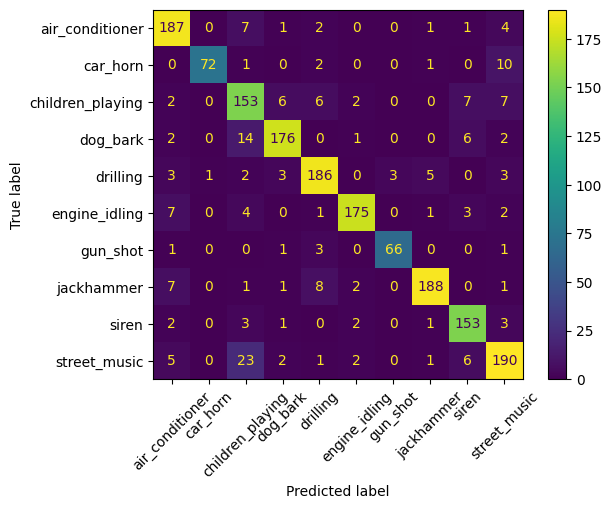

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labelencoder.classes_)
disp.plot(xticks_rotation=45)
plt.show()


In [12]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
report = classification_report(y_true, y_pred_classes, target_names=labelencoder.classes_)
print(report)

55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
                  precision    recall  f1-score   support

 air_conditioner       0.87      0.92      0.89       203
        car_horn       0.99      0.84      0.91        86
children_playing       0.74      0.84      0.78       183
        dog_bark       0.92      0.88      0.90       201
        drilling       0.89      0.90      0.90       206
   engine_idling       0.95      0.91      0.93       193
        gun_shot       0.96      0.92      0.94        72
      jackhammer       0.95      0.90      0.93       208
           siren       0.87      0.93      0.90       165
    street_music       0.85      0.83      0.84       230

        accuracy                           0.88      1747
       macro avg       0.90      0.89      0.89      1747
    weighted avg       0.89      0.88      0.89      1747

